# Imports

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from datetime import date
from datetime import time
from datetime import timedelta
import numpy as np
import bcolz
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
import statsmodels.api as sm

# Load data and make predictions on full dataset

In [2]:
def load_array(fname): 
    return bcolz.open(fname)[:]

def load_resnet_vecs(vec_fname, img_name_fname):
    return load_array(img_name_fname), load_array(vec_fname)

def dtfstr(img_name):
    return datetime.strptime(img_name[:-4], '%Y%m%d%H%M%S')

fnames_all, vecs_all = load_resnet_vecs('vecs_all', 'img_name_all')

In [3]:
df = pd.read_csv('../data/916labels.csv')
df = pd.DataFrame({'img': [x[5:] for x in fnames_all], 'vec_id': range(fnames_all.size)}).merge(df, on='img', how='right')

x_train = vecs_all[df.vec_id].reshape(df.shape[0], 2048)
y_train = np.array(df.guessed)
x_train.shape, y_train.shape

((916, 2048), (916,))

In [4]:
regr = linear_model.Ridge(alpha = 100)
regr.fit(x_train, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [5]:
preds = regr.predict(vecs_all.reshape(vecs_all.shape[0], 2048))

In [6]:
df = pd.DataFrame({'datetime': [dtfstr(x[5:]).replace(second=0) for x in fnames_all], 'swimmers': preds}, 
                  index=[dtfstr(x[5:]).replace(second=0) for x in fnames_all])
df = df.sort_index(axis=0)
df.head(n=10)

,datetime,swimmers
2017-09-06 11:47:00,2017-09-06 11:47:00,-0.256686
2017-09-06 11:48:00,2017-09-06 11:48:00,-0.063244
2017-09-06 11:49:00,2017-09-06 11:49:00,-0.080745
2017-09-06 11:50:00,2017-09-06 11:50:00,0.193153
2017-09-06 11:52:00,2017-09-06 11:52:00,0.106458
2017-09-06 11:53:00,2017-09-06 11:53:00,-0.577290
2017-09-06 11:55:00,2017-09-06 11:55:00,-0.339471
2017-09-06 11:56:00,2017-09-06 11:56:00,0.720139
2017-09-06 11:57:00,2017-09-06 11:57:00,1.236818
2017-09-06 12:00:00,2017-09-06 12:00:00,1.448742


# Overview plots

Swimmers by hour accumulated for each observed day

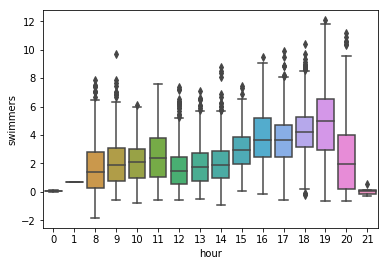

In [7]:
df['hour'] = df.datetime.dt.hour
sns.boxplot(x="hour", y="swimmers", data=df)

Same but only for weekdays

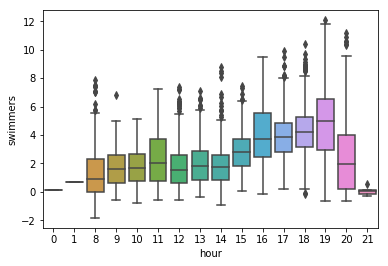

In [8]:
sns.boxplot(x="hour", y="swimmers", data=df[df.datetime.dt.weekday < 5])

Swimmers accumulated by weekday

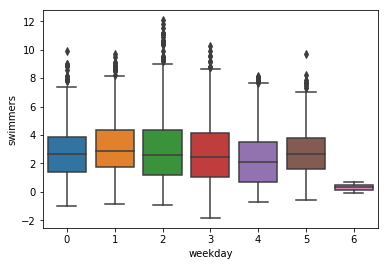

In [14]:
df['weekday'] = df.datetime.dt.weekday
sns.boxplot(x="weekday", y="swimmers", data=df)

How much days do we observe?

In [16]:
df.datetime.dt.dayofyear.unique()

array([249, 250, 251, 252, 253, 254, 255, 256, 257, 259, 261, 262, 263,
       264, 265, 266, 267])

How this days differ from each other by average amount of swimmers?

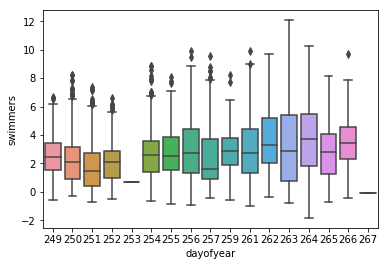

In [17]:
df['dayofyear'] = df.datetime.dt.dayofyear
sns.boxplot(x="dayofyear", y="swimmers", data=df)

Plot each data point for one day (2017-09-21)

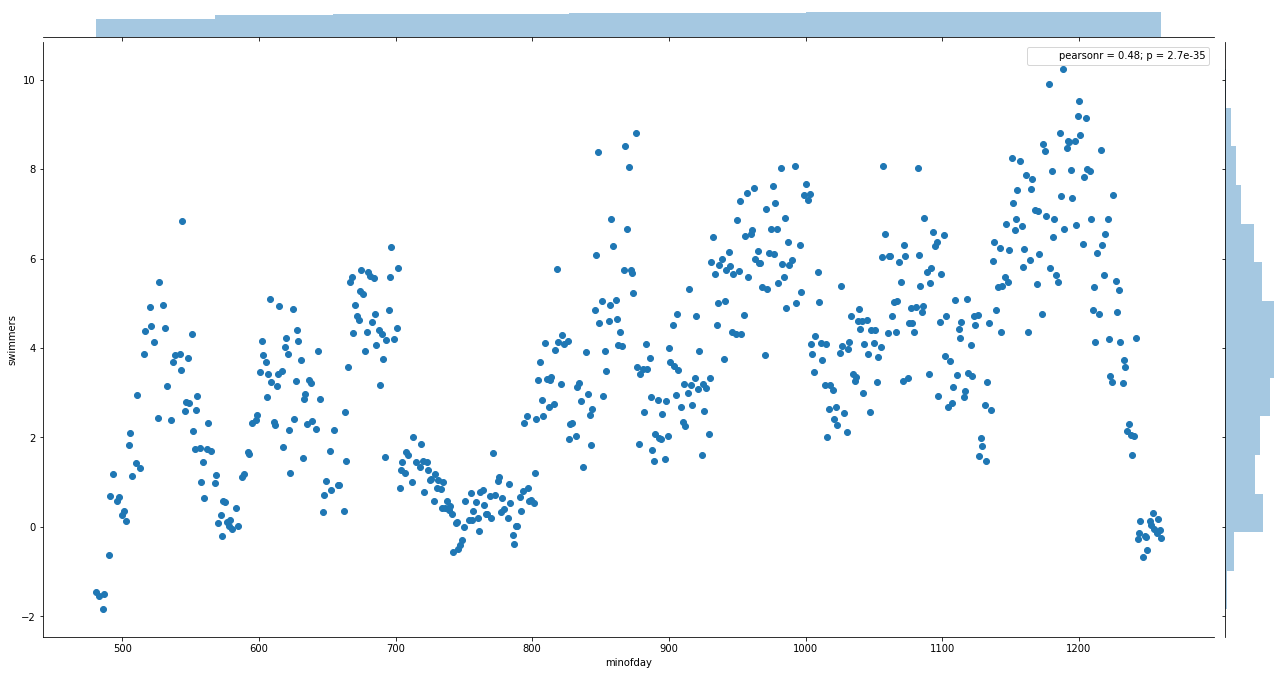

In [9]:
df['minofday'] = df.datetime.dt.hour * 60 + df.datetime.dt.minute
p = sns.jointplot('minofday', 'swimmers', df[df.datetime.dt.day == 21], ratio=19)
p.fig.set_size_inches(20,10)

# Time series daily seasonal decomposition 

Let's check when imgs start and end each day

In [19]:
for i in range(6, 25):
    print(df[df.datetime.dt.day == i].datetime.min(), df[df.datetime.dt.day == i].datetime.max())

2017-09-06 11:47:00 2017-09-06 21:00:00
2017-09-07 08:01:00 2017-09-07 21:57:00
2017-09-08 00:39:00 2017-09-08 21:00:00
2017-09-09 08:02:00 2017-09-09 18:00:00
2017-09-10 11:06:00 2017-09-10 11:06:00
2017-09-11 01:17:00 2017-09-11 21:00:00
2017-09-12 08:02:00 2017-09-12 21:00:00
2017-09-13 08:01:00 2017-09-13 21:01:00
2017-09-14 08:01:00 2017-09-14 19:55:00
NaT NaT
2017-09-16 00:14:00 2017-09-16 18:00:00
NaT NaT
2017-09-18 08:02:00 2017-09-18 21:01:00
2017-09-19 11:40:00 2017-09-19 21:00:00
2017-09-20 08:02:00 2017-09-20 21:00:00
2017-09-21 08:01:00 2017-09-21 21:00:00
2017-09-22 08:01:00 2017-09-22 21:00:00
2017-09-23 08:01:00 2017-09-23 17:59:00
2017-09-24 14:01:00 2017-09-24 14:01:00


Generate all minutes for our days starting from 8h to 21h

In [10]:
d = df.index.min().date()
stop = (df.index.max() + timedelta(1)).date()
d, stop
minutes = []
while d < stop:
    if d == date(2017, 9, 15):
        d = d + timedelta(1)
        continue
    t = datetime.combine(d, time(8, 0))
    stop_t = datetime.combine(d, time(21, 0))
    while t < stop_t:
        minutes.append(t)
        t = t + timedelta(0, 60)
    d = d + timedelta(1)
minutes[:10]

[datetime.datetime(2017, 9, 6, 8, 0),
 datetime.datetime(2017, 9, 6, 8, 1),
 datetime.datetime(2017, 9, 6, 8, 2),
 datetime.datetime(2017, 9, 6, 8, 3),
 datetime.datetime(2017, 9, 6, 8, 4),
 datetime.datetime(2017, 9, 6, 8, 5),
 datetime.datetime(2017, 9, 6, 8, 6),
 datetime.datetime(2017, 9, 6, 8, 7),
 datetime.datetime(2017, 9, 6, 8, 8),
 datetime.datetime(2017, 9, 6, 8, 9)]

In [11]:
len(minutes)

14040

Fill missing minutes with nearest datapoint

In [12]:
df = df.reindex(minutes, method='nearest')
df['datetime'] = df.index
df.head()

,datetime,swimmers,hour,minofday
2017-09-06 08:00:00,2017-09-06 08:00:00,-0.256686,11,707
2017-09-06 08:01:00,2017-09-06 08:01:00,-0.256686,11,707
2017-09-06 08:02:00,2017-09-06 08:02:00,-0.256686,11,707
2017-09-06 08:03:00,2017-09-06 08:03:00,-0.256686,11,707
2017-09-06 08:04:00,2017-09-06 08:04:00,-0.256686,11,707


Get only weekdays, and apply fake seconds frequency for seasonal decomposition

In [14]:
wd = df[df.datetime.dt.dayofweek < 5]
wd.index = pd.date_range(datetime(2000, 1, 1), datetime(2000, 1, 1) + timedelta(0, wd.shape[0] - 1), freq='S')
wd.shape

(9360, 4)

Decompose time series into trend + season + residual. Seems like daily seasonality can explain round half of fluctuations

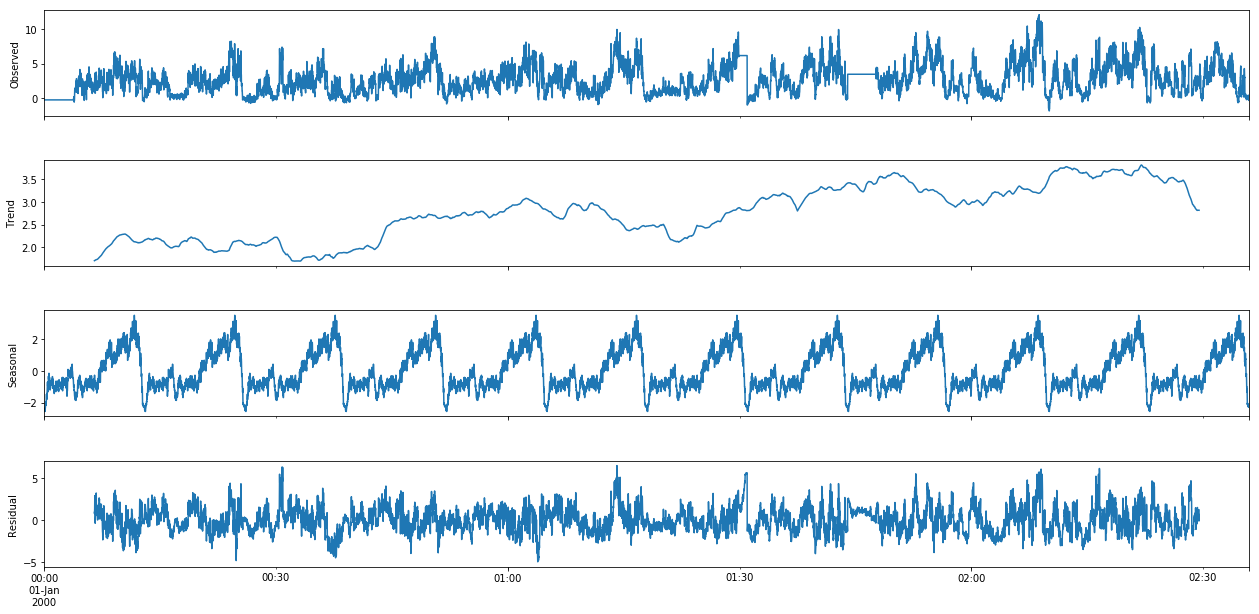

In [15]:
decomposition = sm.tsa.seasonal_decompose(wd['swimmers'], model='additive', freq=13 * 60)
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

To smooth this plot lets aggregate data points by 10 minutes

In [18]:
wd10 = wd.resample('10S').mean()
wd10.shape

(936, 3)

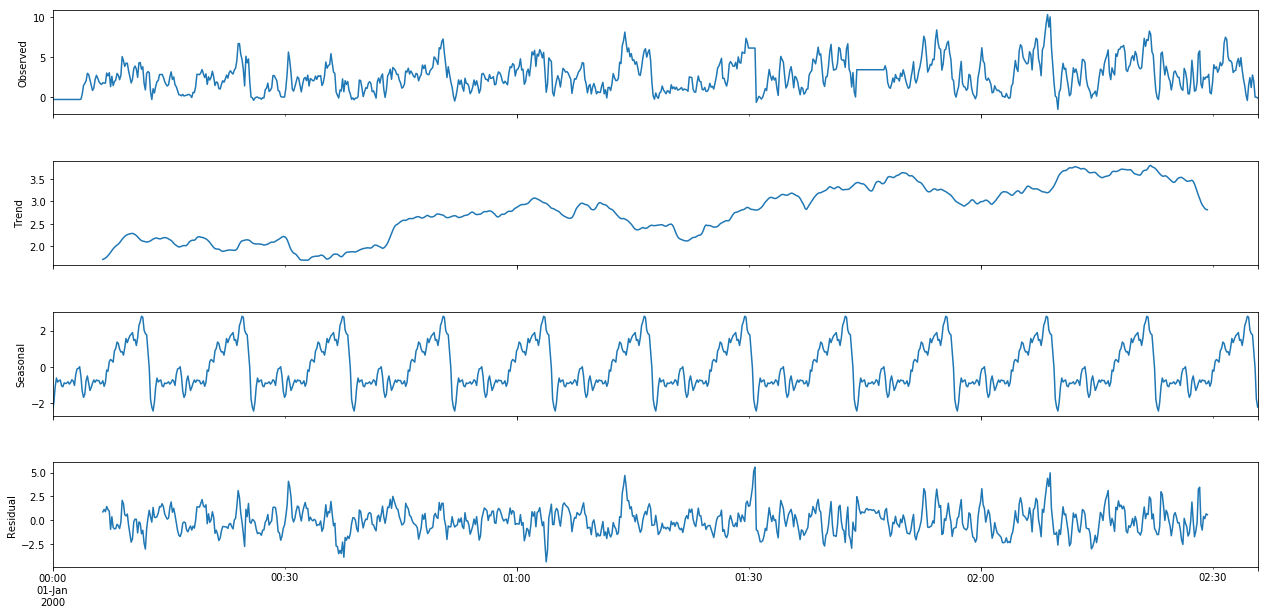

In [19]:
decomposition = sm.tsa.seasonal_decompose(wd10['swimmers'], model='additive', freq=13 * 6)
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

Now let's plot seasonal component, including also min and max number of swimmers for each 10 minute span

In [20]:
hits = {}
for i, x in enumerate(decomposition.resid):
    if pd.isnull(x):
        continue
    ind = i % (13 * 6)
    if not ind in hits:
        hits[ind]=[x]
    else:
        hits[ind].append(x)
        
plot_dt = pd.DataFrame({'min': ['{}:{}'.format(8 + x // 6, 10 * (x % 6)) for x in range(13 * 6)], 
              'seas': decomposition.seasonal[:13 * 6].as_matrix(), 
              'low': [decomposition.seasonal[x] + np.min(hits[x]) for x in range(13 * 6)],
              'high': [decomposition.seasonal[x] + np.max(hits[x]) for x in range(13 * 6)]}, index=range(13 * 6))
plot_dt.head()

,high,low,min,seas
0,0.038013,-5.014428,8:0,-2.438966
1,0.034382,-3.045398,8:10,-1.959943
2,1.879374,-2.685745,8:20,-1.113781
3,2.090202,-2.847626,8:30,-0.620042
4,0.599896,-3.074454,8:40,-0.840548


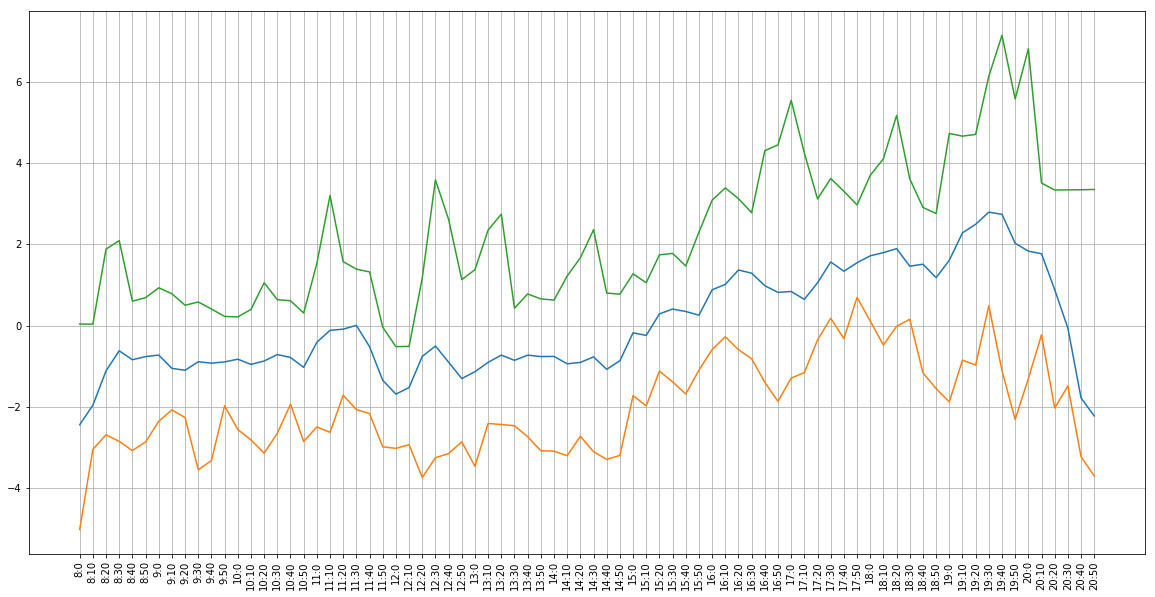

In [21]:
fig, ax = plt.subplots(1,1) 
fig.set_size_inches(20,10)
ax.plot(plot_dt['seas'])
ax.plot(plot_dt['low'])
ax.plot(plot_dt['high'])
ax.set_xticks(range(len(plot_dt['high'])))
ax.set_xticklabels(plot_dt['min'], rotation='vertical', fontsize=10)
plt.grid()
plt.show()

Do the same but for Saturday

In [22]:
hd = df[df.datetime.dt.dayofweek == 5]
hd.index = pd.date_range(datetime(2000, 1, 1), datetime(2000, 1, 1) + timedelta(0, hd.shape[0] - 1), freq='S')
hd.head()

,datetime,swimmers,hour,minofday
2000-01-01 00:00:00,2017-09-09 08:00:00,0.234599,8,482
2000-01-01 00:00:01,2017-09-09 08:01:00,0.234599,8,482
2000-01-01 00:00:02,2017-09-09 08:02:00,0.234599,8,482
2000-01-01 00:00:03,2017-09-09 08:03:00,-0.042145,8,483
2000-01-01 00:00:04,2017-09-09 08:04:00,1.473047,8,485


In [23]:
hd10 = hd.resample('10S').mean()
hd10.shape

(234, 3)

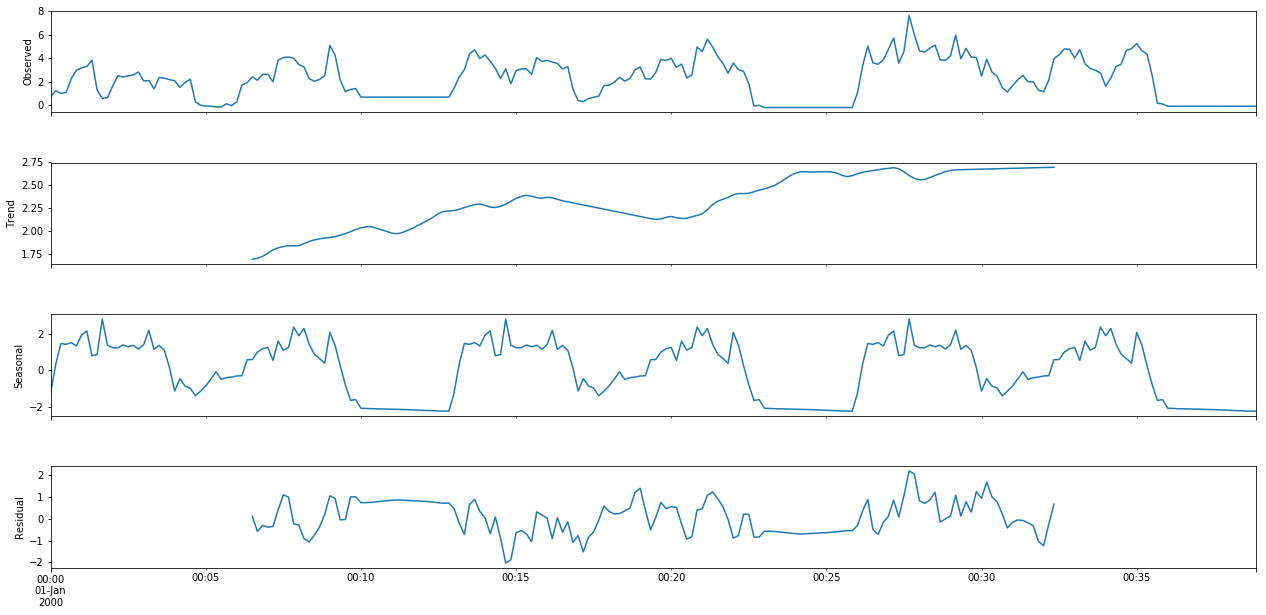

In [24]:
decomposition = sm.tsa.seasonal_decompose(hd10['swimmers'], model='additive', freq=13 * 6)
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

In [25]:
hits = {}
for i, x in enumerate(decomposition.resid):
    if pd.isnull(x):
        continue
    ind = i % (13 * 6)
    if not ind in hits:
        hits[ind]=[x]
    else:
        hits[ind].append(x)
plot_dt = pd.DataFrame({'min': ['{}:{}'.format(8 + x // 6, 10 * (x % 6)) for x in range(13 * 6)], 
              'seas': decomposition.seasonal[:13 * 6].as_matrix(), 
              'low': [decomposition.seasonal[x] + np.min(hits[x]) for x in range(13 * 6)],
              'high': [decomposition.seasonal[x] + np.max(hits[x]) for x in range(13 * 6)]}, index=range(13 * 6))
plot_dt.head()

,high,low,min,seas
0,-0.789729,-1.576511,8:0,-1.273469
1,0.689851,0.148893,8:10,0.329024
2,2.373870,0.762122,8:20,1.477648
3,2.088873,0.946191,8:30,1.427184
4,2.421631,0.812868,8:40,1.526901


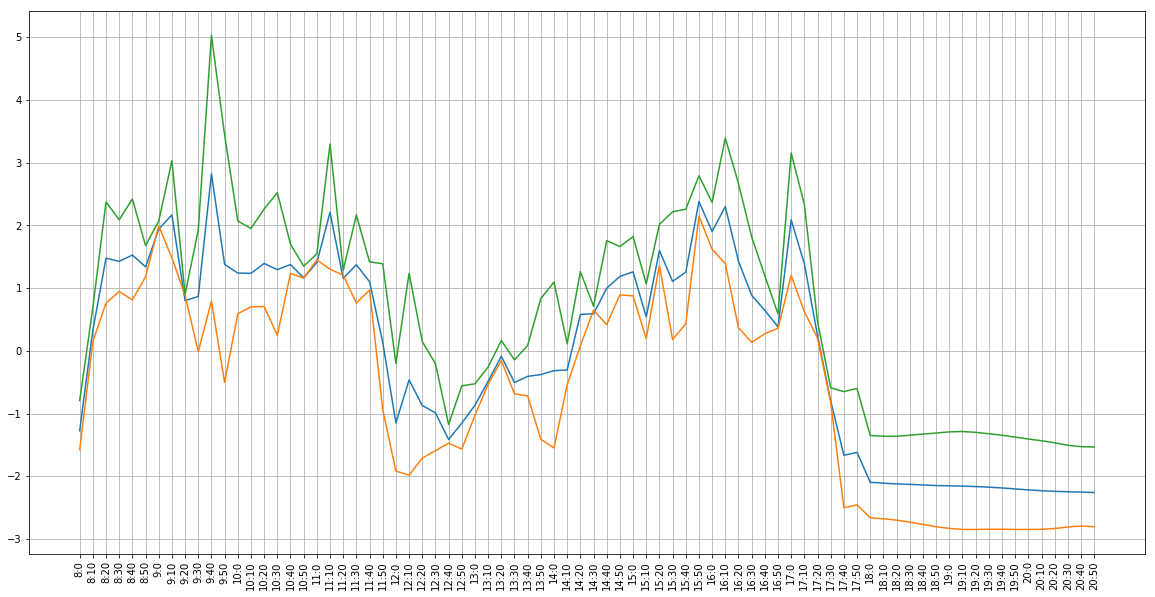

In [26]:
fig, ax = plt.subplots(1,1) 
fig.set_size_inches(20,10)
ax.plot(plot_dt['seas'])
ax.plot(plot_dt['low'])
ax.plot(plot_dt['high'])
ax.set_xticks(range(len(plot_dt['high'])))
ax.set_xticklabels(plot_dt['min'], rotation='vertical', fontsize=10)
plt.grid()
plt.show()